In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/gimli/projects/igre


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from src.models.ig import information_gain as ig
import scipy.signal as sig
from src.data.dir_dataset import load_all_images as lai

## Load Dataset

In [22]:
pd, metadata = lai('/Users/gimli/Qsync/datasets/Girl with the Pearl Earring/Mh670_2018_X-ray_reflection/wt')
xrpd = pd[0,:,:,:]
f, metadata = lai('/Users/gimli/Qsync/datasets/Girl with the Pearl Earring/MA-XRF')
xrf = f[0,:,:]

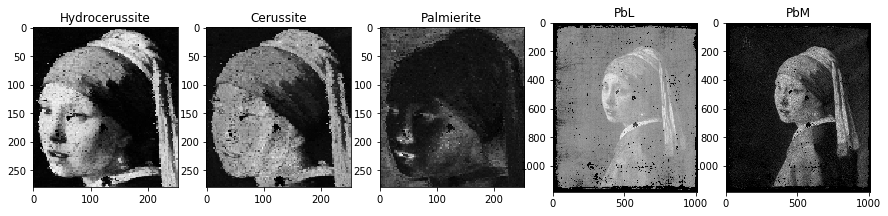

In [25]:
# Check the content
plt.figure(figsize=(15,5))
ax = plt.subplot(1,5,1)
ax.set_title("Hydrocerussite")
ax.imshow(xrpd[:,:,0], cmap="gray")
ax = plt.subplot(1,5,2)
ax.set_title("Cerussite")
ax.imshow(xrpd[:,:,1], cmap="gray")
ax = plt.subplot(1,5,3)
ax.set_title("Palmierite")
ax.imshow(xrpd[:,:,5], cmap="gray")
ax = plt.subplot(1,5,4)
ax.set_title("PbL")
ax.imshow(xrf[:,:,14], cmap="gray")
ax = plt.subplot(1,5,5)
ax.set_title("PbM")
ax.imshow(xrf[:,:,15], cmap="gray")
plt.show()

## Data Registration
- downsample PbL and PbM to XRPD level
- invert transform and prepare upscale transformation

In [27]:
from src.registration.ga import perspective as p

Generation 0, highest fitness 1.3388747138022479.


/Users/gimli/projects/igre/src/measure/mutual_information.py:26: RuntimeWarning: invalid value encountered in true_divide
  a = ((a - np.mean(a)) / np.std(a) * bins).astype(int)


Generation 1, highest fitness 1.3388747138022479.
Generation 2, highest fitness 1.8571067505290983.
Generation 3, highest fitness 1.8571067505290983.
Generation 4, highest fitness 1.8571067505290983.
Generation 5, highest fitness 1.8571067505290983.
Generation 6, highest fitness 1.8571067505290983.
Generation 7, highest fitness 1.8571067505290983.
Generation 8, highest fitness 1.8571067505290983.
Generation 9, highest fitness 1.8571067505290983.
Generation 10, highest fitness 1.8571067505290983.
Generation 11, highest fitness 1.8571067505290983.
Generation 12, highest fitness 1.8571067505290983.
Generation 13, highest fitness 1.8571067505290983.
Generation 14, highest fitness 1.8571067505290983.
Generation 15, highest fitness 1.8571067505290983.
Generation 16, highest fitness 1.8571067505290983.
Generation 17, highest fitness 1.8571067505290983.
Generation 18, highest fitness 1.8571067505290983.
Generation 19, highest fitness 1.8571067505290983.
Generation 20, highest fitness 1.8571067

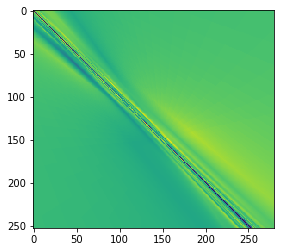

(array([[[786.0901 , 670.4495 ],
         [430.62415, 664.8966 ],
         [206.00755, 446.4896 ],
         [633.66956, 755.2656 ]],
 
        [[273.92975, 253.     ],
         [151.64551, 151.63322],
         [217.3342 , 217.28384],
         [ 92.55608,  92.51362]]], dtype=float32),
 0,
 array([[-3.69545773e-01, -1.29391533e-01,  3.78603532e+02],
        [-3.69814637e-01, -1.28904928e-01,  3.78384962e+02],
        [-2.48377871e-03,  1.42803709e-03,  1.00000000e+00]]))

In [47]:
p.optimize(xrf[:,:,15], xrpd[:,:,0])

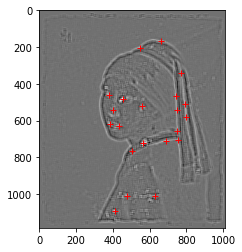

In [345]:
LoG = cv2.Laplacian(cv2.blur(xrf[:,:,15], (17,17),0), cv2.CV_32F, 1, 21)
plt.imshow(LoG, cmap="gray")
coords1 = np.argsort(LoG.reshape(LoG.shape[0] * LoG.shape[1]))[::-1] 
printed1 = []
for coord in coords1:
    c = np.unravel_index(coord, (xrf.shape[0], xrf.shape[1]))
    if not printed1 or np.min([np.linalg.norm(np.array(c) - p) for p in printed1]) > 50:
        printed1.append(np.array(c))
        plt.plot(c[1], c[0], marker="+", color="red")
    if len(printed1) >20:
        break
plt.show()

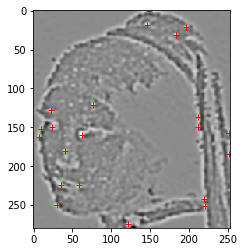

In [346]:
LoG = cv2.Laplacian(xrpd[:,:,0], cv2.CV_32F, 5, 21)
plt.imshow(LoG, cmap="gray")
coords2 = np.argsort(LoG.reshape(LoG.shape[0] * LoG.shape[1]))[::-1] 
printed2 = []
for coord in coords2:
    c = np.unravel_index(coord, (LoG.shape[0], LoG.shape[1]))
    if not printed2 or np.min([np.linalg.norm(np.array(c) - p) for p in printed2]) > 10:
        printed2.append(np.array(c))
        plt.plot(c[1], c[0], marker="+", color="red")
    if len(printed2) >20:
        break
plt.show()

In [347]:
root1 = np.unravel_index(coords1[0], (xrf.shape[0], xrf.shape[1]))
distances1 = sorted([(p, np.arctan((root1-p)[0]/(root1-p)[1])) for p in printed1[1:]], key=lambda x: x[1])
root2 = np.unravel_index(coords2[0], (xrpd.shape[0], xrpd.shape[1]))
distances2 = sorted([(p, np.arctan((root2-p)[0]/(root2-p)[1])) for p in printed2[1:]], key=lambda x: x[1])

In [348]:
angle_match = np.zeros((len(distances1), len(distances2)))
for i1, d1 in enumerate(distances1):
    for i2, d2 in enumerate(distances2):
        angle_match[i1, i2] = d1[1]-d2[1] 

In [349]:
best_angle_matches = np.argsort(np.abs(angle_match).reshape(len(distances1) * len(distances2)))

pts1 = np.zeros((4,2))
pts2 = np.zeros((4,2))
for i, best_angle_match in enumerate(best_angle_matches[:3]):
    idx = np.unravel_index(best_angle_match, (len(distances1), len(distances2)))
    pts1[i+1,:] = distances1[idx[0]][0]
    pts2[i+1,:] = distances2[idx[1]][0]

In [350]:
pts1[0] = root1
pts2[0] = root2
ptsinv1 = np.zeros(pts1.shape)
ptsinv1[:, 0] = pts1[:, 1]
ptsinv1[:, 1] = pts1[:, 0]
ptsinv2 = np.zeros(pts2.shape)
ptsinv2[:, 0] = pts2[:, 1]
ptsinv2[:, 1] = pts2[:, 0]
M = cv2.getPerspectiveTransform(ptsinv1.astype(np.float32), ptsinv2.astype(np.float32))

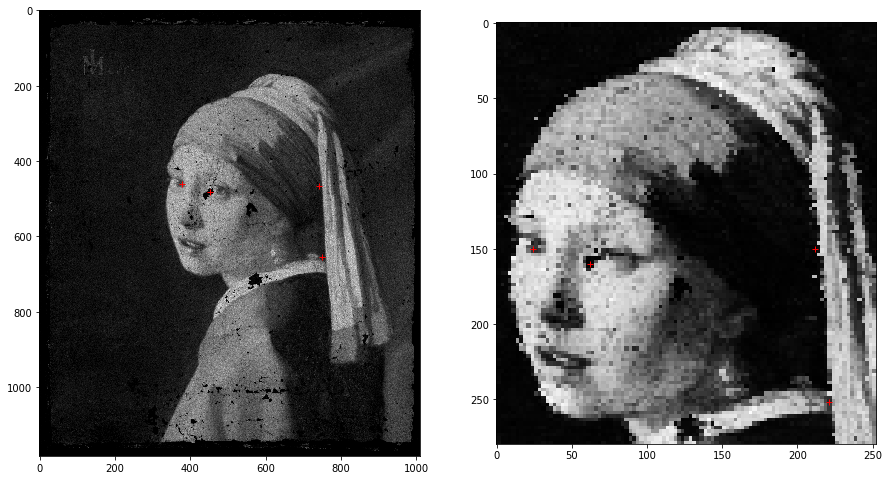

In [351]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
for i in range(4):
    ax.plot(pts1[i][1], pts1[i][0], color="red", marker="+")

ax = plt.subplot(1,2,2)
ax.imshow(xrpd[:,:,0], cmap="gray")
for i in range(4):
    ax.plot(pts2[i][1], pts2[i][0], color="red", marker="+")

plt.show()

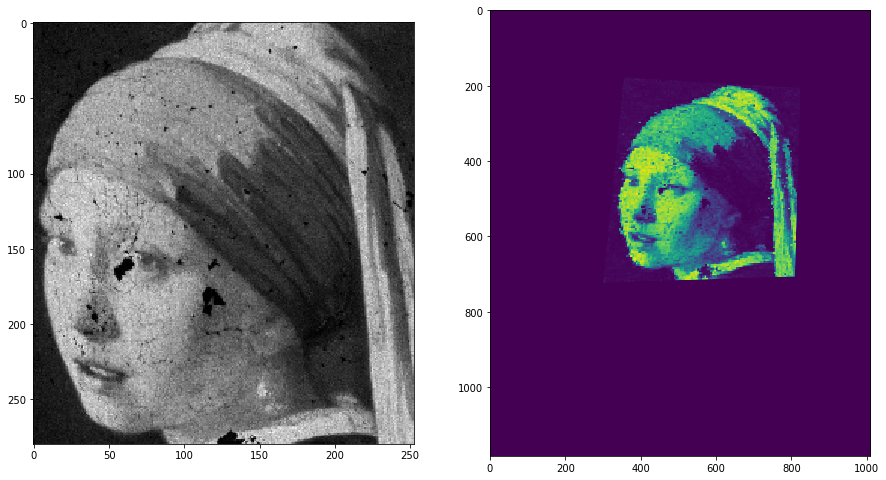

In [352]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(cv2.warpPerspective(xrf[:,:,15], M, (xrpd.shape[1], xrpd.shape[0])), cmap="gray")
ax = plt.subplot(1,2,2)
ax.imshow(cv2.warpPerspective(xrpd[:,:,0], np.linalg.inv(M), (xrf.shape[1], xrf.shape[0])))
plt.show()

In [353]:
# This is perspective transformation equation
def transform_vec(M, v):
    denom = (M[2,0] * v[1] + M[2,1] * v[0] + M[2,2])
    return (M[0,0] * v[1] + M[0,1] * v[0] + M[0,2]) / denom, \
           (M[1,0] * v[1] + M[1,1] * v[0] + M[1,2]) / denom 

In [354]:
LoG = cv2.Laplacian(cv2.blur(xrf[:,:,15], (17,17),0), cv2.CV_32F, 1, 21)
candidates = [(transform_vec(M, np.unravel_index(idx, (LoG.shape[0], LoG.shape[1]))), 
              np.unravel_index(idx, (LoG.shape[0], LoG.shape[1]))) 
                  for idx in np.argsort(np.abs(LoG.reshape(LoG.shape[0] * LoG.shape[1])))[::-1][:3000]]

In [355]:
filtered = []
origs = []
for candidate, orig in candidates:
    if (not filtered or np.min([np.linalg.norm(np.array(f)-np.array(candidate)) for f in filtered]) > 30) \
        and xrpd.shape[0] > candidate[0] > 0 \
        and xrpd.shape[1] > candidate[1] > 0:
        filtered.append(candidate)
        origs.append(orig)

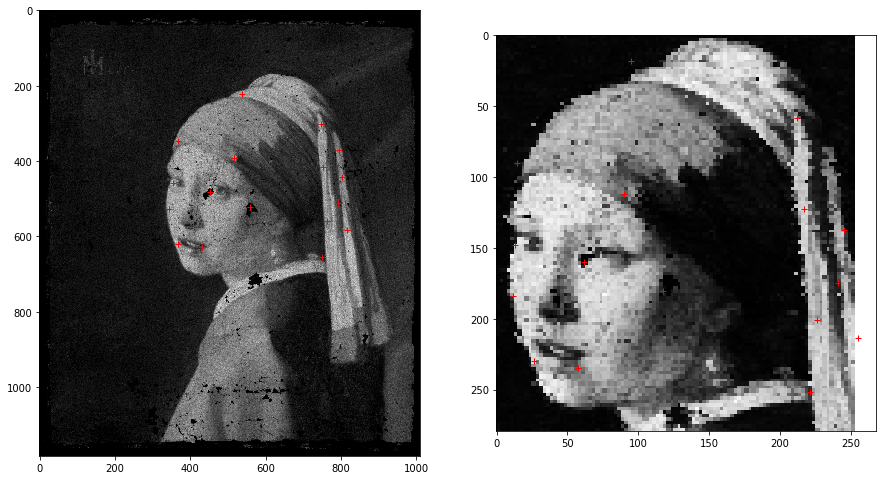

In [356]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
for orig in origs:
    ax.plot(orig[1], orig[0], color="red", marker="+")

ax = plt.subplot(1,2,2)
ax.imshow(xrpd[:,:,0], cmap="gray")
for i in range(len(filtered)):
    ax.plot(filtered[i][0], filtered[i][1], color="red", marker="+")

plt.show()

In [357]:
pd_logs = [(np.unravel_index(coord, (xrpd.shape[0], xrpd.shape[1]))[1],
 np.unravel_index(coord, (xrpd.shape[0], xrpd.shape[1]))[0]) for coord in coords2]

In [358]:
filtered_match = []
for est in filtered:
    for coord in pd_logs:
        if np.linalg.norm(np.array(coord)-np.array(est)) < 20:
            filtered_match.append(coord)
            break

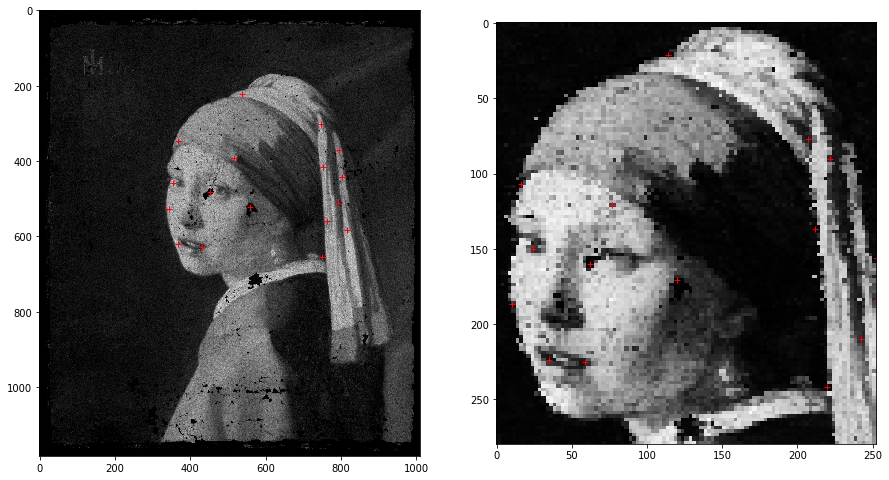

In [359]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
for orig in origs:
    ax.plot(orig[1], orig[0], color="red", marker="+")

ax = plt.subplot(1,2,2)
ax.imshow(xrpd[:,:,0], cmap="gray")
for coord in filtered_match:
    ax.plot(coord[0], coord[1], color="red", marker="+")

plt.show()